# Day 2: Model Discrimination Hackathon

## 1. Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.integrate import odeint
from typing import List, Dict, Tuple, Any, Union, Optional, Callable

## 2. Load Training Data

In [2]:
with open("../training_data_day2.pickle", "rb") as file:
    training_data = pickle.load(file)
display(training_data)

[{'t': array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
          2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
          5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
          7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ]),
  'data': array([[9.68926733e-02, 9.79774616e+00, 0.00000000e+00, 9.48243500e-01],
         [1.25550496e-01, 1.03133981e+01, 7.47152115e-03, 9.60081845e-01],
         [1.58058005e-01, 9.15705989e+00, 1.68532359e-02, 9.24120213e-01],
         [1.98905010e-01, 1.07387421e+01, 2.63126328e-02, 8.17379213e-01],
         [2.57127458e-01, 9.76706610e+00, 4.20730268e-02, 8.31157166e-01],
         [2.82954093e-01, 9.83590563e+00, 6.32762426e-02, 8.17041329e-01],
         [3.60321590e-01, 9.25067852e+00, 7.94909413e-02, 7.38708083e-01],
         [4.43718315e-01, 9.38075374e+00, 1.03450531e-01, 6.37375284e-01],
         [5.02298674e-01, 8.37218002e+00, 1.47336791e-01, 6.62982283e-01],
         [6.53

## 3. Visualise Training Data

In [3]:
def plot_data(
    training_data: List[Dict[str, Any]],
) -> None:
    """
    Plot training data only.

    Parameters
    ----------
    training_data : List[Dict[str, Any]]
        List of dictionaries containing training data with keys:
        't', 'data', and 'initial_conditions'.
    """
    plt.figure(figsize=(15, 10))
    plt.suptitle("Training Data", fontsize=16)

    variables = ["Biomass", "Substrate", "Product", "Inhibitor"]
    colors_training = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#e377c2"]

    for idx, var in enumerate(variables):
        plt.subplot(2, 2, idx + 1)

        # Plot training data and predictions
        for i, exp in enumerate(training_data):
            color = colors_training[i]
            # Training data (circles)
            plt.scatter(
                exp["t"],
                exp["data"][:, idx],
                color=color,
                marker="o",
                alpha=0.6,
                label=f"Training Set {i + 1}",
            )

        plt.xlabel("Time")
        plt.ylabel(var)
        if idx == 0:  # Only show legend for first subplot
            plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()
    return

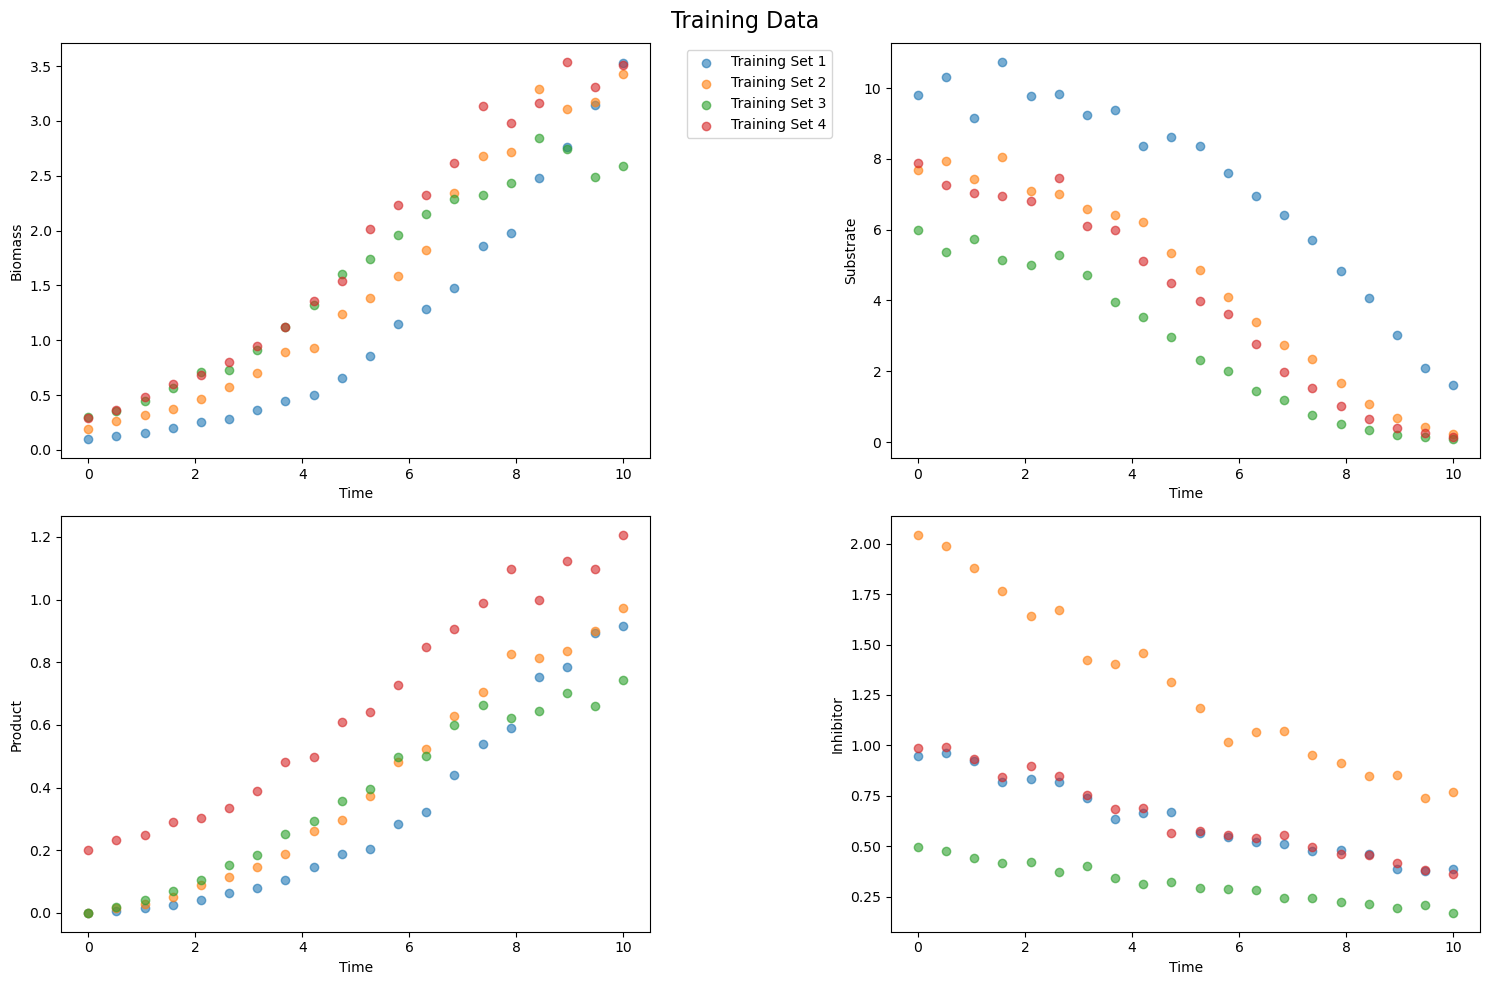

In [4]:
plot_data(training_data=training_data)

## 4. Hackathon!

Your task for this hackathon is to develop an optimizer that will use the given training data for model discrimination and parameter estimation. 

Below you find a function `candidate_models`, which takes the form of a leave function. You can use the parameter `mask`, which is a list of 0s and 1s, to decide which of the candidate terms / leaves are active, i.e. which terms make up the biological model that the optimizer considers to be used for data generation.

At the same time, your task is to identify the optimal values of model parameters, saved as a list in `params`, that match the data best. __In summary, your task is to estimate the model structure and parameter values that best fit the training data visualised above. We will run your algorithm (the optimizer) on an unknown test dataset that is extrapolating beyond the training data we provided.__

As with the previous day, there are two tracks, with further details below.

#### Helper Functions

To get started and help structure your approach, two functions are pre-coded for you:

- ```candidate_models ``` --> structures the leaf functions that could be used to make up your biomodel, and calculates the derivates.

- ```fitness_function``` --> basic routine that quantifies how good a given model is at describing the bio model (based on the training data).

__Note that we will use both of these function to evaluate your submission. Should you wish to use a different fitness function, you have to define it WITHIN your algorithm! See below for further examples.__

In [5]:
def candidate_models(
    y: Union[List[float], np.ndarray],
    t: Union[float, np.ndarray],
    params: List[float],
    mask: List[int],
) -> List[float]:
    """
    Calculate derivatives based on selected growth mechanisms.

    Parameters
    ----------
    y : Union[List[float], np.ndarray]
        State variables [X, S, P, I] representing biomass, substrate,
        product, and inhibitor concentrations.
    t : Union[float, np.ndarray]
        Time point(s) at which to evaluate the model.
    params : List[float]
        Model parameters [mu_max, Ks, Ki, Yxs, Kp].
    mask : List[int]
        Binary mask indicating which growth terms to include.

    Returns
    -------
    List[float]
        Derivatives [dX/dt, dS/dt, dP/dt, dI/dt] at the given time point.
    """
    X, S, P, I = y
    mu_max, Ks, Kp, Yxs, Ki = params

    growth = mu_max * X
    # Growth terms
    # Monod Growth
    if mask[0]:
        growth *= S / (Ks + S)

    # Hill Kinetics Growth
    if mask[1]:
        n = 2
        growth *= S**n / (Ks**n + S**n)

    # Substrate Inhibition Factor
    if mask[2]:
        growth *= 1 / (1 + S / Ki)

    # Product Inhibition Factor (Competitive)
    if mask[3]:
        growth *= (Ks + S) / (S + Ks + (Ks * P / Kp)) # This term is modified so that is can be combined with mask 0 or 1 for a correct inhibition

    # Non-Competitive Product Inhibition
    if mask[4]:
        growth *= 1 / (1 + P / Kp)

    # Competitive Inhibition Factor
    if mask[5]:
        growth *= 1 / (1 + I / Ki)

    # Double Substrate Limited Factor (Inhibitor is a second substrate in case of an inhibitor)
    if mask[6]:
        growth *= I / (Ki + I)

    # Substrate Threshold Activation
    if mask[7]:
        S_threshold = 0.5
        growth *= (S - S_threshold) / (Ks + (S - S_threshold)) if S > S_threshold else 0

    # Inhibitor Saturation
    if mask[8]:
        growth *= 1 / (1 + (P / (P + Ki)))

    # Calculate derivatives
    dX = growth
    dS = -(growth / Yxs)
    dP = 0.3 * growth
    dI = -0.1 * I

    return [dX, dS, dP, dI]

In [6]:
def fitness_function(
    mask: List[int],
    params: List[float],
    training_data: List[Dict[str, Any]],
) -> Tuple[float, Optional[List[float]]]:
    """
    Calculate fitness of a solution.

    Parameters
    ----------
    mask : List[int]
        Binary mask indicating which growth terms to include.
    params : List[float]
        Model parameters [mu_max, Ks, Ki, Yxs, Kp].
    training_data : List[Dict[str, Any]]
        Training data to evaluate fitness against.

    Returns
    -------
    Tuple[float, Optional[List[float]]]
        Tuple containing:
        - Negative total error (including complexity penalty)
        - List of errors for each experiment (or None if error occurred)
    """
    total_error = 0
    n_active_terms = sum(mask)

    errors_by_experiment = []
    for experiment in training_data:
        t = experiment["t"]
        y_true = experiment["data"]
        y0 = experiment["initial_conditions"]

        try:
            y_pred = odeint(
                lambda y, t: candidate_models(y, t, params, mask),
                y0,
                t,
            )
            error = np.mean((y_true - y_pred) ** 2)
            total_error += error
            errors_by_experiment.append(error)
        except:
            return float("-inf"), None

    return -total_error, errors_by_experiment

### Tracks & Submission

#### Track 1

The first track will be working on a __local random search__, an outline of which is given below. Please make sure that you follow the signature of the function to be compliant with our test platform. In the final evaluation, we will limit the product of `iterations` and `sample` to __3,000__. Please modify the default values in the function below, but make sure to stay below this limit so that your algorithm is approved for benchmarking.

__IMPORTANT:__ Please do not change the name of the function. It has to be `local_search_optimize` and must feature all five input arguments and the three return values as shown below.


In [5]:
def local_search_optimize(params_start, masks_start, training_data, iterations=100, samples=10): # TODO: Change the default values!
    """
    Local search optimizer template for continuous and binary variables.
    
    Parameters
    ----------
    params_start : array-like
        Initial continuous parameters (e.g. shape (num_params,)).
    masks_start : array-like
        Initial binary masks (e.g. shape (num_masks,)).
    training_data : List[Dict[str, Any]]
        Provided data to fit or evaluate the model.
    iterations : int, optional
        Number of outer iterations.
    samples : int, optional
        Number of new candidate solutions to explore per iteration.

    Returns
    -------
    best_obj_value : float
        The best (minimum) objective value found.
    best_params : np.ndarray
        Continuous parameters corresponding to the best found solution.
    best_masks : np.ndarray
        Binary mask corresponding to the best found solution.
    """
    # Step 1: Initialize any required hyperparameters for local search
    #   - For instance, set a radius/step-size for continuous perturbations
    #   - Decide on a probability/frequency for flipping bits of the binary mask
    # TODO: radius = ?
    # TODO: flip_prob = ?
    
    # Step 2: Store the initial solution in "best" variables
    #   - Convert to NumPy arrays for easy manipulation
    # TODO: best_params = ?
    # TODO: best_masks = ?
    
    # Step 3: Evaluate the initial solution to get the baseline "best_obj_value"
    best_obj_value = -fitness_function(
        mask=best_masks, params=best_params, training_data=training_data
    )[0]

    # Main optimization loop
    for iter_idx in range(iterations):
        # Step 4: For each outer iteration, try a certain number of new samples
        #   - This is the local "search" around the current best solution
        for _ in range(samples):
            pass
            # Step 4a: Generate a new "candidate" solution
            #   - For continuous parameters: create a perturbation vector
            #   - For binary masks: possibly flip bits with some probability
            # TODO: params_candidate = ?
            # TODO: masks_candidate = ?

            # Step 4b: Evaluate the candidate solution
            #   - Again, call the objective function
            # TODO: candidate_obj_value = ?

            # Step 4c: Compare candidate vs. current best
            #   - If candidate is better, update best solution and break inner loop
            # TODO: if candidate is better: update best_obj_value, best_params, best_masks
            # TODO: break the inner loop if improvement is found

            # Step 5: If no improvement was found in the entire inner loop
            #   - Possibly shrink the perturbation radius to focus on smaller moves
            # TODO: radius *= ?

        # Step 6 (optional): Print or log progress
        #   - For debugging or demonstration
        # print(f"Iter {iter_idx} | Best objective: {best_obj_value}")

    # Step 7: Return the best found solution and its objective value
    return best_obj_value, best_params, best_masks

In [ ]:
# Step A: Define initial guesses for continuous and binary variables
# Note you should not change the starting points as in the assessment
# we will randomly initialise these values
params_start = np.random.uniform(-1, 1, size=5)  # 5 continuous parameters
masks_start = np.random.randint(0, 2, size=9)  # 9 binary masks

# Step B: Call the local search function
best_val, best_params, best_masks = local_search_optimize(
    params_start=params_start,
    masks_start=masks_start,
    training_data=training_data,
    iterations=100,
    samples=10,
)

# Print final results
print("\nFinal Results:")
print(f"Best objective value: {best_val}")
print(f"Best params: {best_params}")
print(f"Best masks: {best_masks}")

##### Track 2

The second track will be working on a genetic algorithm. Similarly, please ensure that you have the right function signature as shown below. In particular, your submission must use the argument `population_size` with a default value that is smaller or equal to `20`. In the final evaluation, we will limit the overall run time of your optimizer and enforce the population size.

__IMPORTANT:__ Above you see a basic fitness function. Should you call `basic_fitness_function` within your genetic algorithm, we will benchmark you using the shown `fitness_function`. Should you wish to use another function, you must define it within the `genetic_algorithm` and NOT use the `basic_fitness_function` argument. However, do not change the function signature even if your are not using all five input arguments.

Example:

```
def genetic_algorithm(
    training_data: List[Dict[str, Any]],
    population_size: int = 20,
    candidate_models: Callable = candidate_models,
    basic_fitness_function: Callable = fitness_function,
    best_container=None,
) -> Dict[str, Any]:

    def my_fitness():
        ...
        return
    
    error = my_fitness()
```

In the end, we will benchmark you only using whatever code is defined within `genetic_algorithm`. There is no need to copy the candidate terms for the model, just use the `candidate_models` argument. It will call the function defined above in the benchmarking automatically. Below you find the signature and hints to implement the genetic algorithm. Please make sure to save your progress after each iteration in `best_container` as shown below since we might stop your algorithm earlier.

In [ ]:
import random

def genetic_algorithm(
    training_data: List[Dict[str, Any]],
    population_size: int = 20,
    candidate_models: Callable = candidate_models,
    basic_fitness_function: Callable = fitness_function,
    best_container=None,
) -> Dict[str, Any]:
    """
    Genetic algorithm that performs model selection and parameter estimation.

    Parameters
    ----------
    training_data : List[Dict[str, Any]]
        Training data to fit the model to.
    population_size : int
        Number of individuals in the population.
    candidate_models : Callable
        Calculate derivatives based on selected growth mechanisms.
    basic_fitness_function : Callable
        Evaluates fitness of a candidate solution based on model performance.
    best_container : dict
        IMPORTANT! Stores the best candidate found.
        Since we will stop your code after a certain run_time, always store the
        best individual of each iteration here!

    Returns
    -------
    Dict[str, Any]
        Best individual found (keys must be `mask` and `params`).
    """
    # Step 1: Define hyperparameters such as generations, mutation_rate etc.
    generations = ... # TODO: define here
    mutation_rate = ... # TODO: define here

    # Step 2: Initialize population - you MUST keep random initialization
    population = [
        {
            "mask": np.random.randint(0, 2, size=9),
            "params": [
                np.random.uniform(0.0, 5.0),  # mu_max
                np.random.uniform(0.0, 5.0),  # Ks
                np.random.uniform(0.0, 5.0),  # Ki
                np.random.uniform(0.0, 1.0),  # Yxs
                np.random.uniform(0.0, 5.0),  # Kp
            ],
        }
        for _ in range(population_size)
    ]
    best_fitness = float("-inf")

    # IMPORTANT: You have to use a function return that is a dictionary
    # with keys `mask` and `params` and list items! Here is a template

    best_individual = {"mask": [], "params": []}
    best_errors = None


    for gen in range(generations):
        # Step 3: Evaluate fitness of current population

        if current_best > best_fitness:

            # TODO: implement your evaluation

            # IMPORTANT!!! Leave this in here and always save best_individual for our benchmarking!
            if best_container is not None:
                best_container["best"] = best_individual

        # Step 5 (Optional): Track history, e.g. for plotting


        # Step 6: Selection - keep a percentage of best candidates from the previous population


        # Step 7: Create new population
        new_population = []
        for _ in range(population_size // 2): # TODO: Change this if you want to keep less / more of the population
            # Step 8: Select parents

            # Step 9: Create child

            # Step 10: Parameter crossover


            # Step 11: Mutation

            new_population.append({"mask": ..., "params": ...})

        population.extend(new_population)


        # IMPORTANT: Catch all masks zero i.e., no active leaves
        if sum(best_individual["mask"]) == 0:
            random_idx = random.randint(0, len(best_individual["mask"]) - 1)
            best_individual["mask"][random_idx] = 1

    return best_individual

### Submission

Please make sure that you try to submit your algorithm in time to avoid conflicts with our testing framework. You need to make sure that you stick to the correct signature and constraints set for the parameters for benchmarking.

As with the previous day, submission is via the live streamlit hackathon app, where you will need to submit your optimizer with the correct name and function signature.

You may submit only submit once during the hackathon, after which the assessment will take place.